<a href="https://colab.research.google.com/github/shuahoon/CODSOFT/blob/main/Spam%20SMS%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!python3 -m nltk.downloader wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...
unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [14]:
import pandas as pd

# Try reading the CSV file with a different encoding, like 'latin1'
df = pd.read_csv("spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [17]:
df.drop(df.columns[2:].values, axis=1, inplace=True)
df.rename(columns={"v1": "label", "v2": "sms"}, inplace=True)

df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


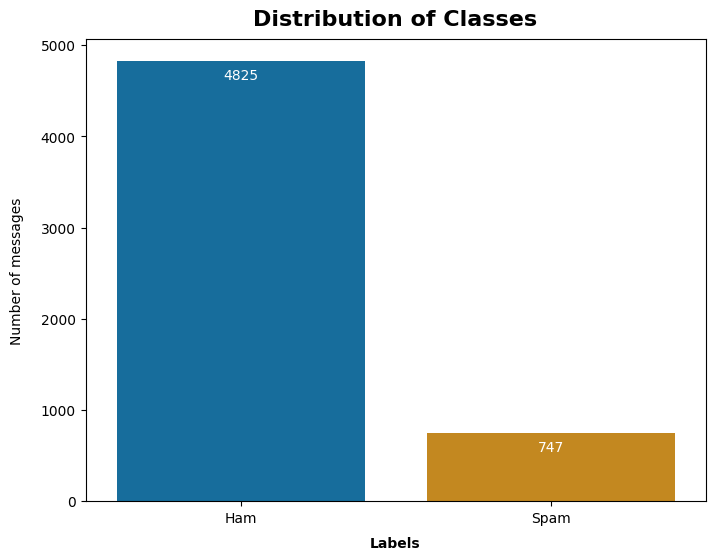

In [18]:
plt.style.use(plt.style.available[12])

fig = plt.figure(figsize=(8, 6))
fig = sns.countplot(x=df['label'], palette=sns.color_palette('colorblind'))

fig.set_title("Distribution of Classes", fontdict={'fontsize':16, 'fontweight':'bold'}, pad=10)
for container in fig.containers:
    fig.bar_label(container, label_type='edge', color='#fff', padding=-15)

fig.set_ylabel("Number of messages", labelpad=12, fontsize=10)
fig.set_xlabel("Labels", labelpad=8, fontsize=10, fontweight='bold')
fig.set_xticks([0, 1], ["Ham", "Spam"])

plt.show()

In [20]:
import nltk
nltk.download('punkt')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
df['n_characters'] = df.sms.apply(len)
df['n_sentences'] = df.sms.apply(lambda row: sent_tokenize(row)).apply(len)
df['n_words'] = df.sms.apply(lambda row: word_tokenize(row)).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
n_sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0
n_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0


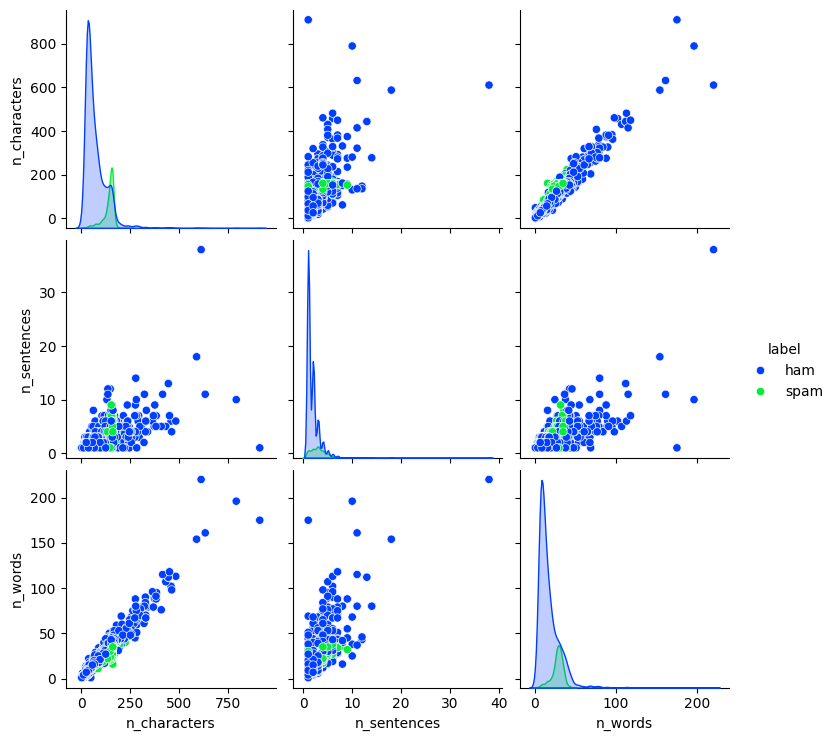

In [22]:
sns.pairplot(data=df, hue='label')
plt.show()

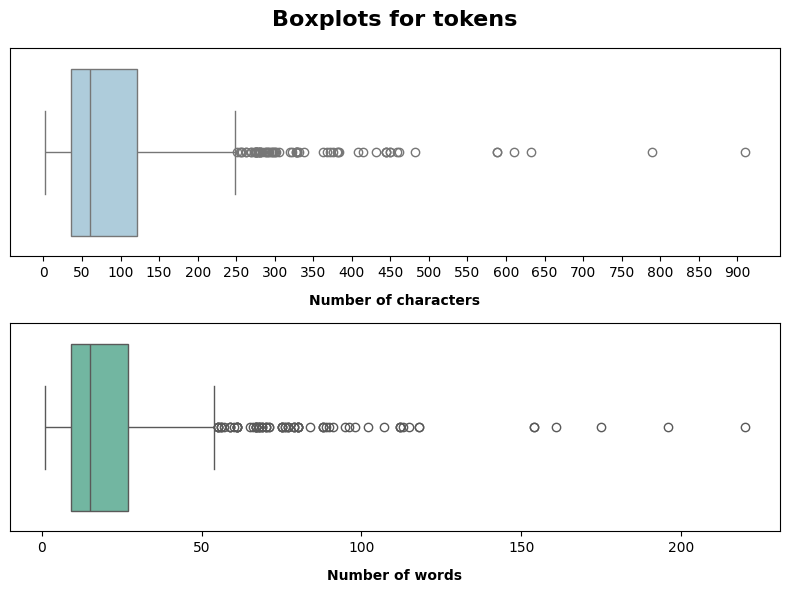

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=False)
fig.suptitle("Boxplots for tokens", size=16, weight='bold')

sns.boxplot(x='n_characters', data=df, palette=sns.color_palette('Paired'), ax=ax[0])
ax[0].set_xlabel("Number of characters", size=10, labelpad=10, fontweight='bold')
ax[0].set_yticks([])
ax[0].set_xticks([i for i in range(0, 950, 50)])

sns.boxplot(x='n_words', data=df, palette=sns.color_palette('Set2'), ax=ax[1])
ax[1].set_xlabel("Number of words", size=10, labelpad=10, fontweight='bold')
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

In [24]:
data = df[df.n_characters < 250]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5504 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         5504 non-null   object
 1   sms           5504 non-null   object
 2   n_characters  5504 non-null   int64 
 3   n_sentences   5504 non-null   int64 
 4   n_words       5504 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 258.0+ KB


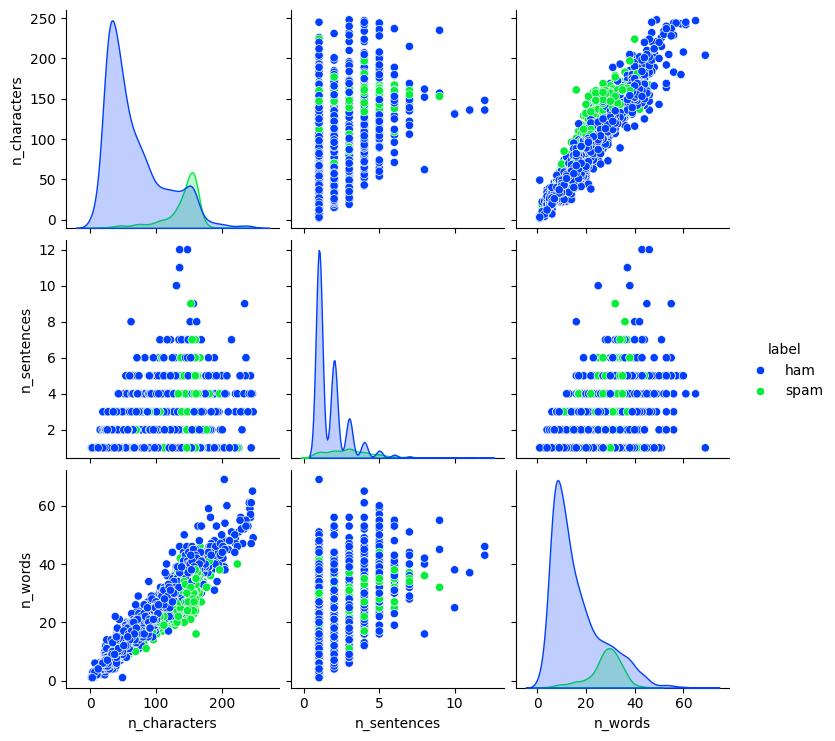

In [25]:
sns.pairplot(data, hue='label')
plt.show()

In [26]:
def clean_sms(sms: str) -> str:
    x = re.sub(r'[^a-zA-Z]', ' ', sms).strip()
    x = map(lambda word: word.strip().lower(), x.split(' '))
    cleaned_sms = ' '.join([word for word in x if word != ''])
    return cleaned_sms

data.sms = data.sms.apply(clean_sms)
for sms in data.sms.head().values:
    print(sms)

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [27]:
data['tokenized_sms'] = data.sms.apply(lambda row: word_tokenize(row))

for t_sms in data.tokenized_sms.head().values:
    print(t_sms, end='\n\n')

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']

['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']

['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']



In [29]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the 'stopwords' dataset
nltk.download('stopwords')

def clean_sms(sms: str) -> str:
    x = re.sub(r'[^a-zA-Z]', ' ', sms).strip()
    x = map(lambda word: word.strip().lower(), x.split(' '))
    cleaned_sms = ' '.join([word for word in x if word != ''])
    return cleaned_sms

# Assuming 'data' is your DataFrame with an 'sms' column
data.sms = data.sms.apply(clean_sms)

data['tokenized_sms'] = data.sms.apply(lambda row: word_tokenize(row))

# Now, you can access stopwords
stops = set(stopwords.words("english"))
data['non_stop_sms'] = data.tokenized_sms.apply(lambda row: [word for word in row if word not in stops])

print(f'SMS : "{data.sms.loc[0]}"\n\nTokenized SMS length\t: {len(data.tokenized_sms.loc[0])}\nNon-stopword SMS length\t: {len(data.non_stop_sms.loc[0])}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


SMS : "go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat"

Tokenized SMS length	: 20
Non-stopword SMS length	: 16


In [31]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sms(words: pd.Series) -> list[str]:
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return lemmas

data['lemma_sms'] = data['non_stop_sms'].apply(lemmatize_sms)

for l_sms in data.lemma_sms.head().values:
    print(l_sms, end='\n\n')

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']

['ok', 'lar', 'joke', 'wif', 'u', 'oni']

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']

['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']

['nah', 'think', 'go', 'usf', 'live', 'around', 'though']



In [32]:
corpus = data['lemma_sms'].apply(lambda row: ' '.join(row))

corpus[:5]

,lemma_sms
0,go jurong point crazy available bugis n great ...
1,ok lar joke wif u oni
2,free entry wkly comp win fa cup final tkts st ...
3,u dun say early hor u c already say
4,nah think go usf live around though


In [33]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()

X.shape

(5504, 6333)

In [34]:
encoder = LabelEncoder()
data.label = encoder.fit_transform(data.label)

data.label.head()

,label
0,0
1,0
2,1
3,0
4,0


In [35]:
y = data.label
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=33)

X_train.shape, X_test.shape

((4403, 6333), (1101, 6333))

In [36]:
pipeline = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(warm_start=True, max_iter=200, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100),
    'Random Forest Classifier': RandomForestClassifier(warm_start=True, n_estimators=35, n_jobs=-1)
}

print("Cross-validation scores - Mean accuracy\n")

for name, model in pipeline.items():
    model.fit(X_train, y_train)
    score = cv_score(model, X_train, y_train, scoring='accuracy', cv=10)
    print(f"{name} : {(score.mean() * 100):.2f}%")

Cross-validation scores - Mean accuracy

Gaussian Naive Bayes : 86.17%
Logistic Regression : 95.71%
Decision Tree Classifier : 96.02%
Random Forest Classifier : 97.75%


In [37]:
preds = {}
labels=['Ham', 'Spam']

def report(*args):
    print(f"{args[0]}\n")
    y_pred = args[1].predict(X_test)
    preds.update({args[0] : y_pred})

    print(classification_report(y_test.astype('int'), y_pred))
    print(f"Accuracy score : {(accuracy_score(y_test.astype('int'), y_pred) * 100):.2f}%", end='\n\n')

for i, item in enumerate(pipeline.items()):
    report(*item)
    if i != len(pipeline) - 1:
        print()

Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       952
           1       0.53      0.91      0.67       149

    accuracy                           0.88      1101
   macro avg       0.76      0.89      0.80      1101
weighted avg       0.92      0.88      0.89      1101

Accuracy score : 87.74%


Logistic Regression

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       952
           1       0.99      0.75      0.85       149

    accuracy                           0.97      1101
   macro avg       0.98      0.88      0.92      1101
weighted avg       0.97      0.97      0.96      1101

Accuracy score : 96.55%


Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       952
           1       0.92      0.83      0.87       149

    accuracy                           0.97      1101
   macr

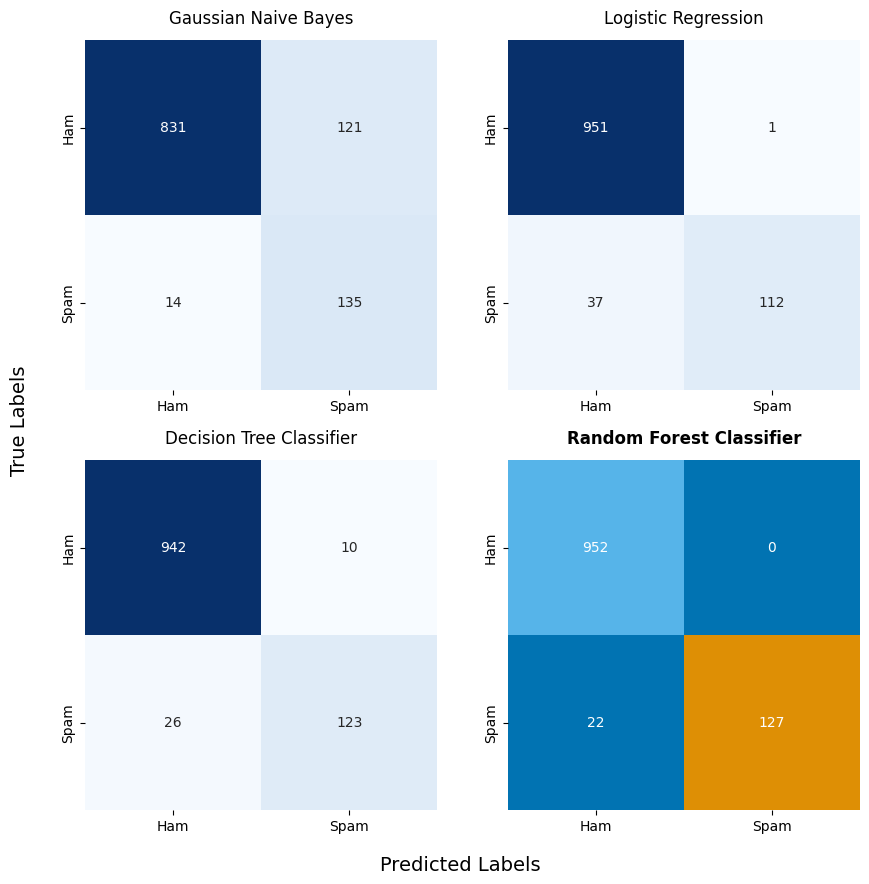

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.text(0.5, 0.05, 'Predicted Labels', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'True Labels', va='center', rotation='vertical', fontsize=14)

for ax, (name, model) in zip(axs.flatten(), pipeline.items()):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False, cmap=sns.color_palette('colorblind', as_cmap=True) if name == 'Random Forest Classifier' else 'Blues')

    ax.set_title(f"{name}", pad=12, fontweight='bold' if name == 'Random Forest Classifier' else 'light', fontsize=12)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

plt.show()

In [40]:
import os
import pickle

model_filename = r'/kaggle/working/rfc-model.pkl'
vectorizer_filename = r'/kaggle/working/tfidf-vectorizer.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_filename), exist_ok=True)

# Now you can safely dump the model
pickle.dump(pipeline['Random Forest Classifier'], open(model_filename, 'wb'))
pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

In [41]:
loaded_model = pickle.load(open(model_filename, 'rb'))
loaded_vectorizer = pickle.load(open(vectorizer_filename, 'rb'))

loaded_model

RandomForestClassifier(n_estimators=35, n_jobs=-1, warm_start=True)

In [42]:
sample = "Want to win $5,000 in this summer’s treasure hunt? Text “YES” to 4555 to reserve your ticket.T&Cs apply. "

vector = loaded_vectorizer.transform([sample]).toarray()
pred_label = "HAM" if loaded_model.predict(vector.reshape(1, -1))[0] == 0 else "SPAM"

print(f"""
SMS message\t:  "{sample}"
True label\t:  SPAM
Predicted label\t:  {pred_label}
""")


SMS message	:  "Want to win $5,000 in this summer’s treasure hunt? Text “YES” to 4555 to reserve your ticket.T&Cs apply. "
True label	:  SPAM
Predicted label	:  SPAM

